In [33]:
cd '/n/holylfs/LABS/wadduwage_lab/Lab/navodini/dCNN_Datasets/Blood_Vessels/6SLS'

/n/holylfs/LABS/wadduwage_lab/Lab/navodini/dCNN_Datasets/Blood_Vessels/6SLS


In [34]:
ls '/n/holylfs/LABS/wadduwage_lab/Lab/navodini/dCNN_Datasets/Blood_Vessels/6SLS'

mouse_bv_300um_data_6sls_2.295395e+01mc21-Oct-2021 21:39:52_pram_plusplus.mat
mouse_bv_300um_data_6sls_2.295395e+01mcanml1_r1_300um_exp.h5
mouse_bv_300um_data_6sls_2.295395e+01mcanml1_r2_300um_exp.h5
mouse_bv_300um_data_6sls_2.295395e+01mcanml2_r1_300um_exp.h5
mouse_bv_300um_data_6sls_2.295395e+01mcanml2_r2_300um_exp.h5
mouse_bv_300um_data_6sls_2.295395e+01mc_test.h5
mouse_bv_300um_data_6sls_2.295395e+01mc_tr.h5


In [35]:
import h5py
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import mat73
from skimage.transform import rescale
import torch
import torch.nn.functional as F
# !pip install apeer-ometiff-library
# from apeer_ometiff_library import io

# Putting all together

In [36]:
def read_data(filename, filename_test, forward_data):
    with h5py.File(filename, "r") as f:
        a_group_key = list(f.keys())[0]  # List all groups
        b_group_key = list(f.keys())[1]
        data = list(f[a_group_key])  # Get the data

    with h5py.File(filename_test, "r") as f:
        key = list(f.keys())[0]  # List all groups
        key2 = list(f.keys())[1]
        data_test = list(f[key])          # Get the data
        # input_img_test = list(f[key2])
        
    data_dict = mat73.loadmat(forward_data)
    Ex = data_dict['E']

    PSFs_dict = data_dict['PSFs']
    # print(PSFs_dict.keys())
    emPSF = data_dict['PSFs']['emPSF']
    # exPSF = data_dict['PSFs']['exPSF']
    sPSF = data_dict['PSFs']['sPSF']
    pram_PSF = data_dict['PSFs']['pram']
    pram_dict = data_dict['pram']
    # print(data_dict.keys())
    # rescale_ratio = pram_PSF['dx']/pram_dict['dx']
    
    return data, data_test, Ex, sPSF, emPSF, pram_PSF, pram_dict

In [37]:
filename = 'mouse_bv_300um_data_6sls_2.295395e+01mc_tr.h5'
filename_test = 'mouse_bv_300um_data_6sls_2.295395e+01mc_test.h5'
forward_data = 'mouse_bv_300um_data_6sls_2.295395e+01mc21-Oct-2021 21:39:52_pram_plusplus.mat'

data, data_test, Ex, sPSF, emPSF, pram_PSF, pram_dict = read_data(filename, filename_test, forward_data)

print(f"Number of data available (train) : {len(data)}")
print(f"Shape of an image {data[0].shape}")
print(f"Number of data available (test) : {len(data_test)}")
print(f"Shape of an image {data_test[0].shape}")
print(f"Shape of Exication pattern data {Ex.shape}")
print(f"Shape of emPSF data {emPSF.shape}")
print(f"Shape of sPSF data {sPSF.shape}")

Number of data available (train) : 11345
Shape of an image (1, 326, 326)
Number of data available (test) : 128
Shape of an image (1, 326, 326)
Shape of Exication pattern data (326, 326, 32)
Shape of emPSF data (1305, 1305, 67)
Shape of sPSF data (1305, 1305, 67)


In [38]:
def forward_model(sPSF, emPSF, pram_PSF, pram_dict):
    rescale_ratio = pram_PSF['dx']/pram_dict['dx']  # Get te=he rescale ratio (Navodhini's code)
    print(f"Rescale ratio used : {rescale_ratio/2}")
    sliced = sPSF.shape[-1]//2  # Get the slice in center from 3D stack
    print(f"Slice No in center : {sliced}")
    sPSF_2d = sPSF[:,:,sliced]
    emPSF_2d = emPSF[:,:,sliced]

    sPSF_2d_scaled =  rescale(sPSF_2d, rescale_ratio, anti_aliasing=True)
    emPSF_2d_scaled = rescale(emPSF_2d, rescale_ratio, anti_aliasing=True)
    
    return sPSF_2d_scaled, emPSF_2d_scaled

Rescale ratio used : 0.25
Slice No in center : 33
(652, 652)


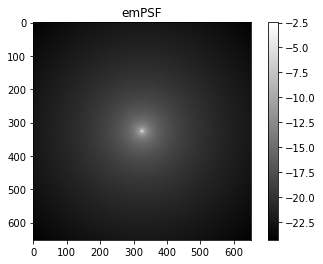

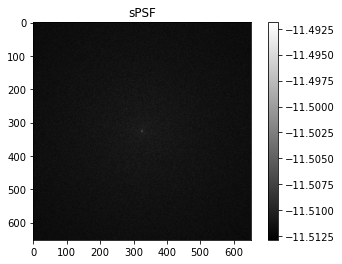

In [40]:
sPSF_2d_scaled, emPSF_2d_scaled = forward_model(sPSF, emPSF, pram_PSF, pram_dict)

print(sPSF_2d_scaled.shape)
plt.imshow(np.log(emPSF_2d_scaled),cmap = 'gray'), plt.title('emPSF') ; plt.colorbar(); plt.show()
plt.imshow(np.log(sPSF_2d_scaled+1e-5), cmap = 'gray'), plt.title('sPSF') ; plt.colorbar(); plt.show()



In [44]:
def conv2d_freq(A,B):
    C = []
    # fft_Ny = A.shape[0]+B.shape[0]
    # fft_Nx = A.shape[1]+ B.shape[1]
    # print(A.shape[-1])
    for i in range(0,A.shape[-1]):
        Mul = np.multiply(np.fft.fft2(A[:,:,i]),np.fft.fft2(B)) #,(fft_Ny,fft_Nx)
        Out = np.fft.ifft2(Mul)
        Out = np.fft.ifftshift((np.real(Out)))
        C.append(Out)
    C = np.array(C)
        # print(Out.shape)
    return C

In [45]:
def get_output(i,data,Ex,sPSF_2d_scaled, emPSF_2d_scaled):
    input_image = data[i]
    print(input_image.shape)
    patterned = input_image.reshape(326,326,1) * Ex 
    print(patterned.shape)
    
    plt.imshow(input_image.squeeze(),cmap = 'gray') ; plt.title('Input Image'); plt.colorbar(); plt.show()
    plt.imshow(patterned[:,:,0], cmap = 'gray'); plt.title('Patterned'); plt.colorbar(); plt.show()

    
    sPSF_convolved = conv2d_freq(patterned,sPSF_2d_scaled)
    Out = conv2d_freq(np.moveaxis(sPSF_convolved,0,-1),emPSF_2d_scaled)
    print(sPSF_convolved.shape)
    plt.imshow(np.mean(sPSF_convolved,axis=0),cmap = 'gray')
    plt.colorbar()
    plt.show()
    plt.imshow(np.mean(Out,axis=0),cmap = 'gray')
    plt.colorbar()
    plt.show()
    
    return Out
    

(1, 326, 326)
(326, 326, 32)


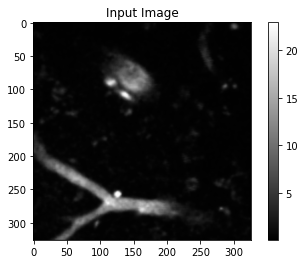

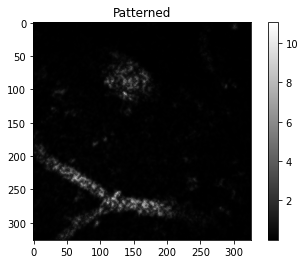

ValueError: operands could not be broadcast together with shapes (326,326) (652,652) 

In [46]:
Out = get_output(5,data,Ex,sPSF_2d_scaled, emPSF_2d_scaled)

# Dataset

In [11]:
filename = 'mouse_bv_300um_data_6sls_2.295395e+01mc_tr.h5'
filename_test = 'mouse_bv_300um_data_6sls_2.295395e+01mc_test.h5'
with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    b_group_key = list(f.keys())[1]
    # Get the data
    data = list(f[a_group_key])
    # input_im = list(f[b_group_key])
    
with h5py.File(filename_test, "r") as f:
    # List all groups
    key = list(f.keys())[0]
    key2 = list(f.keys())[1]
    # Get the data
    data_test = list(f[key])
    input_img_test = list(f[key2])

Keys: <KeysViewHDF5 ['gt', 'input']>


In [12]:
print(f"Number of data available (train) : {len(data)}")
print(f"Shape of an image {data[0].shape}")
print(f"Number of data available (test) : {len(data_test)}")
print(f"Shape of an image {data_test[0].shape}")

Number of data available (train) : 11345
Shape of an image (1, 326, 326)
Number of data available (test) : 128
Shape of an image (1, 326, 326)


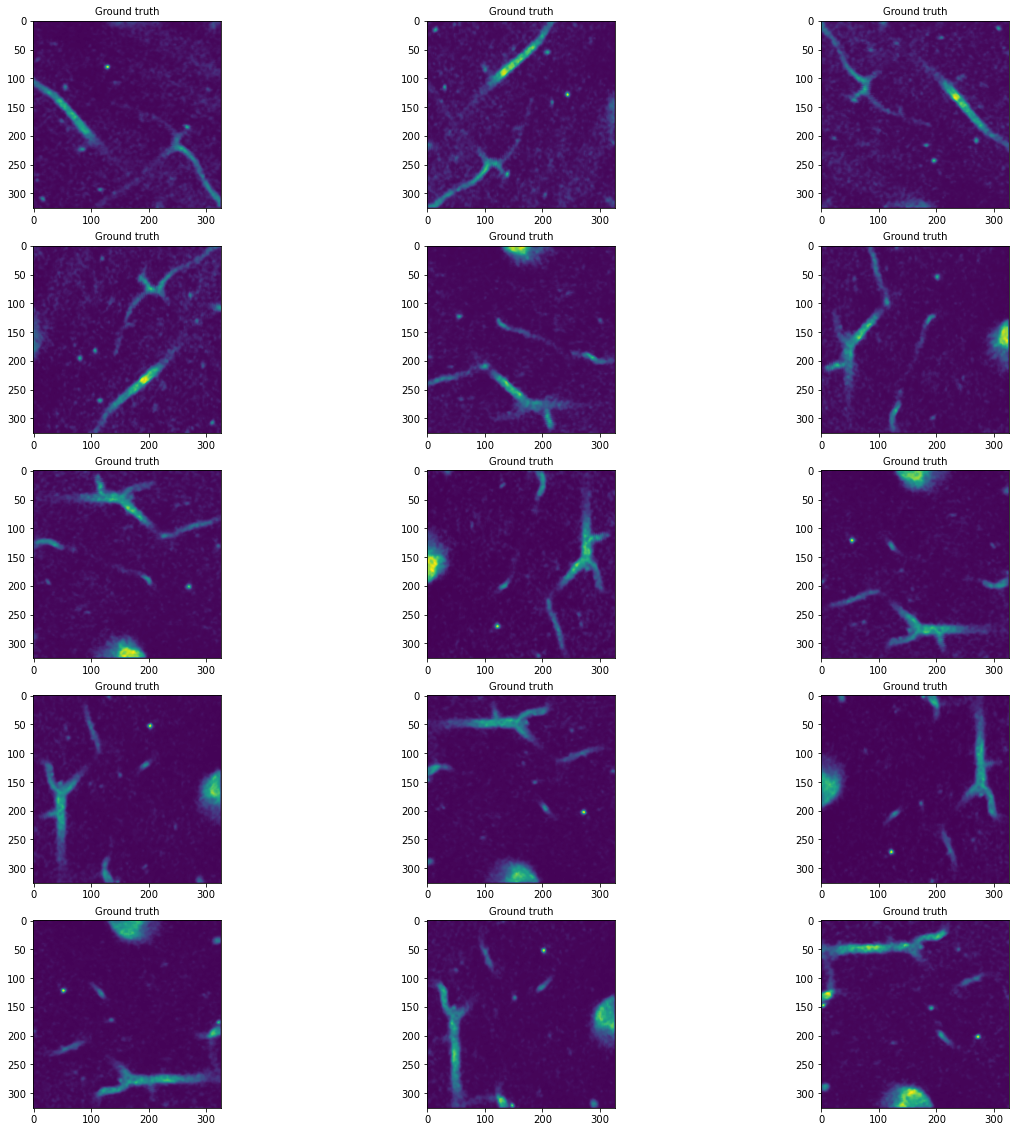

In [13]:
rows,cols=5,3
fig=plt.figure(figsize=(20,20))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img=data_test[i-1].squeeze()
    plt.imshow(img)#,cmap='gray')
    plt.title("Ground truth",fontsize = 10)
plt.show()

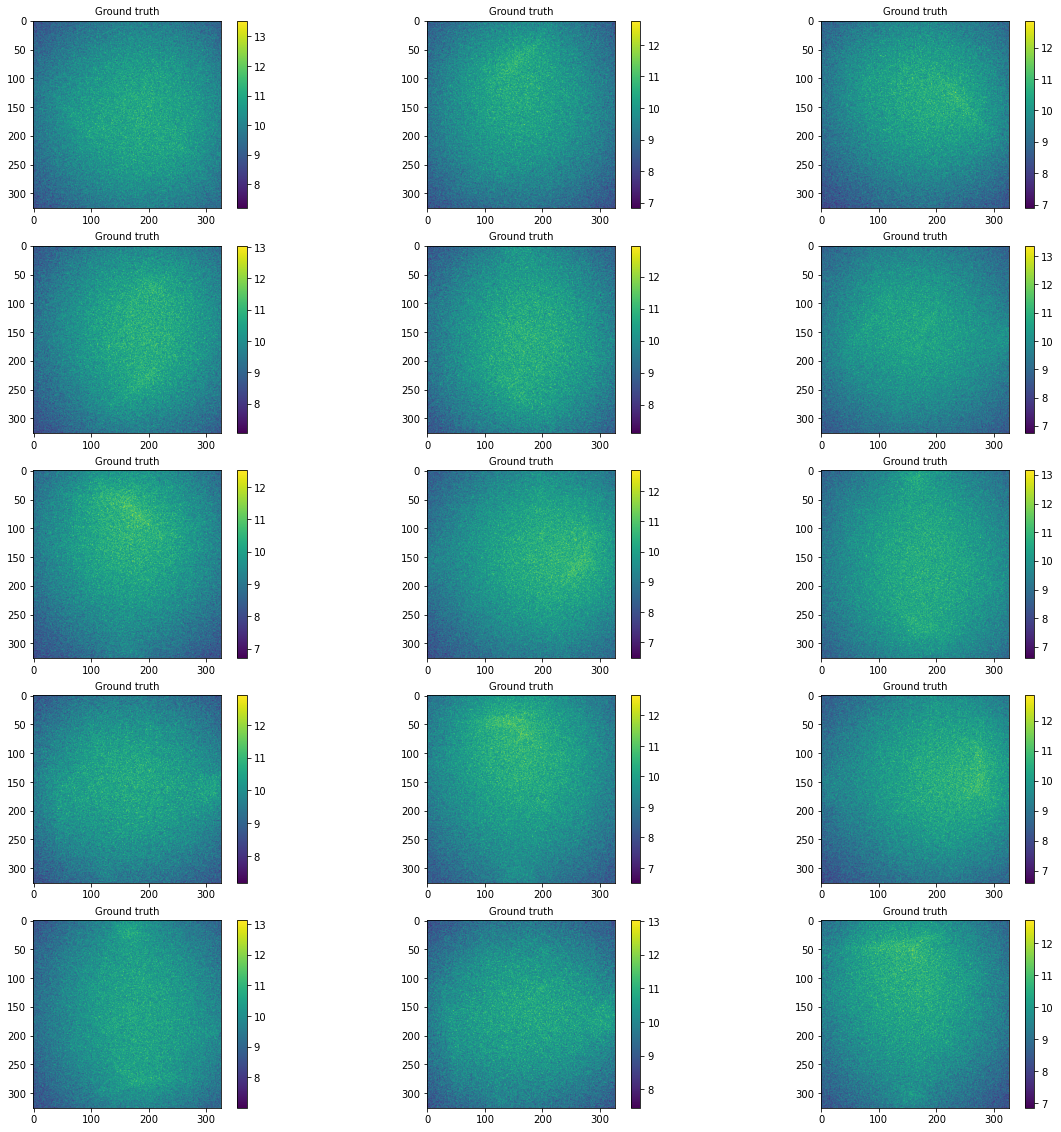

In [14]:
rows,cols=5,3
fig=plt.figure(figsize=(20,20))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img=np.mean(input_img_test[i-1],axis=0)
    # img=input_img_test[i-1][0]
    # print(img.shape)
    plt.imshow(img)#,cmap='gray'
    plt.colorbar()
    plt.title("Ground truth",fontsize = 10)
plt.show()

# to_compare = input_img_test[0],axis = 0)

# Excitation patterns, PSFs

In [15]:
mat_fname = 'mouse_bv_300um_data_6sls_2.295395e+01mc21-Oct-2021 21:39:52_pram_plusplus.mat'
data_dict = mat73.loadmat(mat_fname)
print(data_dict.keys())

dict_keys(['E', 'PSFs', 'X_refs', 'Y_exp', 'pram'])


In [16]:
Ex = data_dict['E']

PSFs_dict = data_dict['PSFs']
print(PSFs_dict.keys())
emPSF = data_dict['PSFs']['emPSF']
exPSF = data_dict['PSFs']['exPSF']
sPSF = data_dict['PSFs']['sPSF']
pram_PSF = data_dict['PSFs']['pram']

X_refs_dict = data_dict['X_refs']
Y_exp_dict = data_dict['Y_exp']
pram_dict = data_dict['pram']

dict_keys(['emPSF', 'exPSF', 'pram', 'sPSF'])


In [17]:
print(f"Shape of Exication pattern data {Ex.shape}")
print(f"Shape of emPSF data {emPSF.shape}")
print(f"Shape of exPSF data {exPSF.shape}")
print(f"Shape of sPSF data {sPSF.shape}")

Shape of Exication pattern data (326, 326, 32)
Shape of emPSF data (1305, 1305, 67)
Shape of exPSF data (1305, 1305, 67)
Shape of sPSF data (1305, 1305, 67)


In [18]:
# testing
#whether excitation pattern generated and loaded from header file are same or not
# for 300um

# E_copy = E.copy()
# print(E_copy.shape)
# Ek = E_copy[:,:,31]
# Ek == Ex[:,:,31]

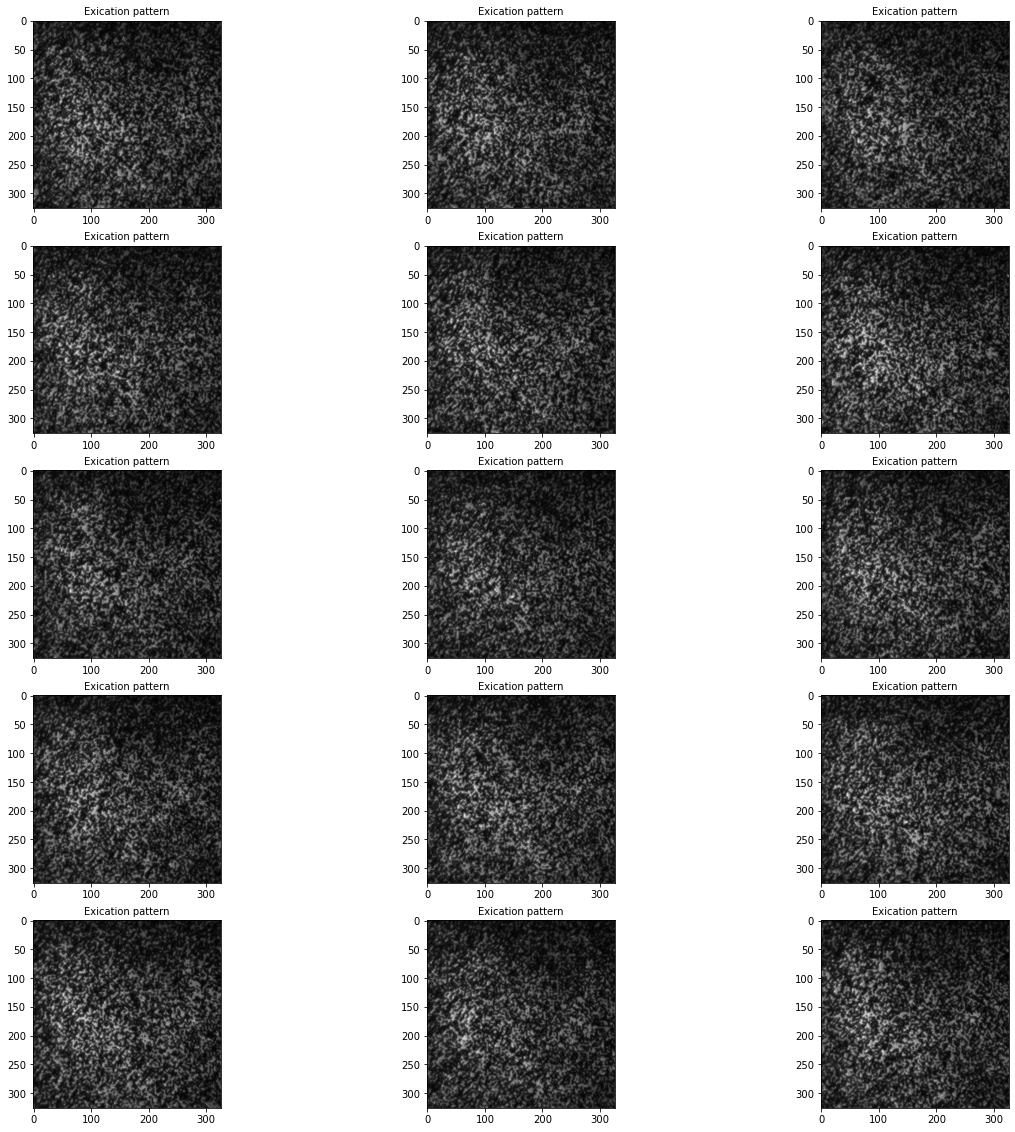

In [19]:
rows,cols=5,3
fig=plt.figure(figsize=(20,20))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img=Ex[:,:,i-1]
    plt.imshow(img,cmap='gray')
    plt.title("Exication pattern",fontsize = 10)
plt.show()

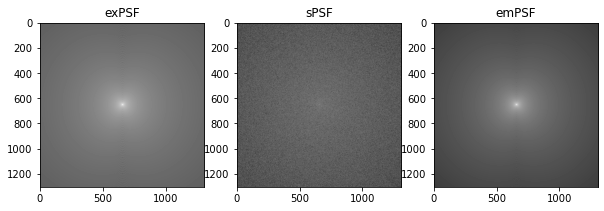

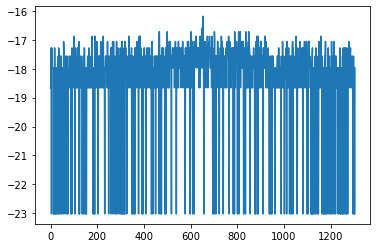

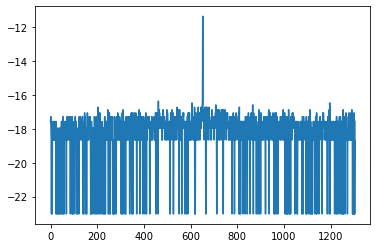

(1305, 1305)

In [30]:
# for k in range (0,66):
k = 33
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(np.log(exPSF[:,:,k]),cmap = 'gray'), ax[0].set_title('exPSF')
ax[1].imshow(np.log(sPSF[:,:,k]+1e-10), cmap = 'gray'), ax[1].set_title('sPSF')
ax[2].imshow(np.log(emPSF[:,:,k]), cmap = 'gray'), ax[2].set_title('emPSF')
plt.show()


plt.plot(np.log(sPSF[653,:,k]+1e-10))
plt.show()
plt.plot(np.log(sPSF[652,:,k]+1e-10))
plt.show()

exPSF[:,:,k].shape

# Get forward model output

(1, 326, 326)
(326, 326, 32)


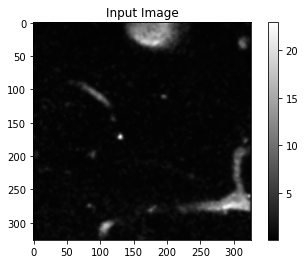

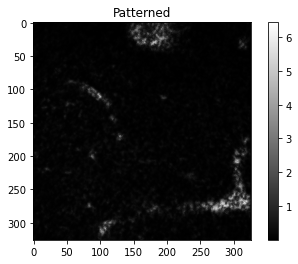

22.953955 0.061575342
11.377525 0.0
1.0 0.0


In [21]:
input_image = data_test[20]
# input_image = (input_image  - np.min(input_image)) / (np.max(input_image) - np.min(input_image))
print(input_image.shape)
patterned = input_image.reshape(326,326,1) * Ex 
print(patterned.shape)

plt.imshow(input_image.squeeze(),cmap = 'gray') ; plt.title('Input Image'); plt.colorbar(); plt.show()
plt.imshow(patterned[:,:,0], cmap = 'gray'); plt.title('Patterned'); plt.colorbar(); plt.show()

print(np.max(input_image),np.min(input_image))
print(np.max(patterned),np.min(patterned))
print(np.max(Ex),np.min(Ex))

In [22]:
# print(pram_PSF)
print(pram_dict['dx'],pram_PSF['dx'])
rescale_ratio = pram_PSF['dx']/pram_dict['dx']
print(rescale_ratio)

0.33 0.165
0.5


In [23]:
sliced = sPSF.shape[-1]//2
print(sliced)
sPSF_2d = sPSF[:,:,sliced]
emPSF_2d = emPSF[:,:,sliced]


sPSF_2d_scaled =  rescale(sPSF_2d, rescale_ratio/2, anti_aliasing=True)
emPSF_2d_scaled = rescale(emPSF_2d, rescale_ratio/2, anti_aliasing=True)

print(np.max(sPSF_2d_scaled),np.min(sPSF_2d_scaled))
print(emPSF_2d_scaled.shape)

33
1.82691278088313e-07 5.50984737151392e-09
(326, 326)


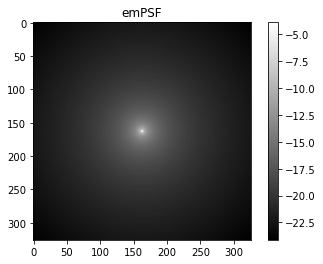

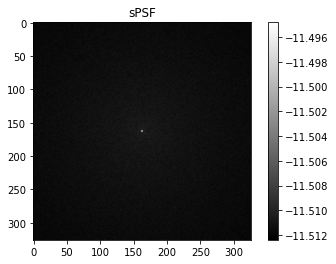

In [24]:
plt.imshow(np.log(emPSF_2d_scaled),cmap = 'gray'), plt.title('emPSF') ; plt.colorbar(); plt.show()
plt.imshow(np.log(sPSF_2d_scaled+1e-5), cmap = 'gray'), plt.title('sPSF') ; plt.colorbar(); plt.show()

## Conv2D in frequency domain

In [25]:
def f_conv2nd(A,B):
    C = []
    fft_Ny = A.shape[0]+B.shape[0]
    fft_Nx = A.shape[1]+ B.shape[1]
    # print(A.shape[-1])
    for i in range(0,A.shape[-1]):
        Mul = np.fft.fft2(A[:,:,i]) * np.fft.fft2(B) #,(fft_Ny,fft_Nx)
        Out = np.fft.ifft2(Mul)
        Out = np.fft.ifftshift((np.real(Out)))
        C.append(Out)
    C = np.array(C)
        # print(Out.shape)
    return C
    

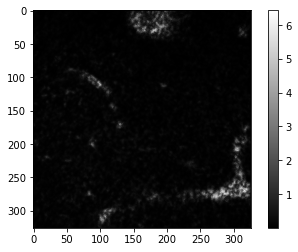

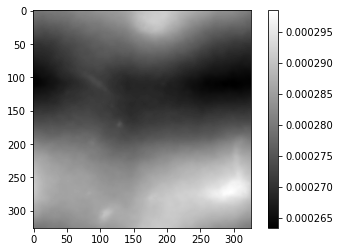

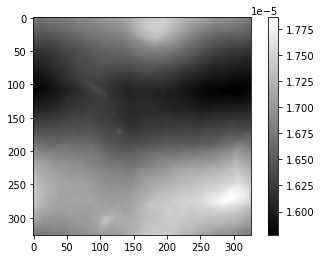

In [26]:
sPSF_convolved = f_conv2nd(patterned,sPSF_2d_scaled)
Out = f_conv2nd(np.moveaxis(sPSF_convolved,0,-1),emPSF_2d_scaled)
plt.imshow(patterned[:,:,0],cmap = 'gray')
plt.colorbar()
plt.show()
plt.imshow(np.mean(sPSF_convolved,axis=0),cmap = 'gray')
plt.colorbar()
plt.show()
plt.imshow(np.mean(Out,axis=0),cmap = 'gray')
plt.colorbar()
plt.show()
# plt.imshow(sPSF_convolved[0,:,:])
# plt.show()
# plt.imshow(np.moveaxis(sPSF_convolved,0,-1)[:,:,0])
# plt.show()

## Conv2D 

In [27]:
No_of_patterns = 1#Ex.shape[-1]
print(No_of_patterns)

final_output = np.zeros((No_of_patterns,326,326))

input_image = data_test[0]
print(input_image.shape)
patterned = input_image.reshape(326,326,1) * Ex 
print(patterned.shape)

for i in range(No_of_patterns):
    pattern = torch.tensor(patterned[:,:,i].reshape(1,1,326,326),requires_grad=False)
    weights_sPSF = torch.tensor(sPSF_2d_scaled.astype(np.float32),requires_grad=False)
    weights_emPSF = torch.tensor(emPSF_2d_scaled.astype(np.float32),requires_grad=False)

    x_dim,y_dim = sPSF_2d_scaled.shape[0], sPSF_2d_scaled.shape[1]
    weights_sPSF = weights_sPSF.view(1, 1,x_dim , y_dim)#.repeat(1, 1, 1, 1)
    weights_emPSF = weights_emPSF.view(1, 1,x_dim , y_dim)
    
    
    output_1 = F.conv2d(pattern, weights_sPSF, padding='same')
    print(output_1.shape)
    output_2 = F.conv2d(output_1, weights_emPSF,padding='same')
    final_output[i,:,:] = output_2.squeeze()

print(final_output.shape)

1
(1, 326, 326)
(326, 326, 32)


/n/home12/mithunjha/.conda/envs/deep_tfm/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811792945/work/aten/src/ATen/native/Convolution.cpp:647.)


torch.Size([1, 1, 326, 326])
(1, 326, 326)


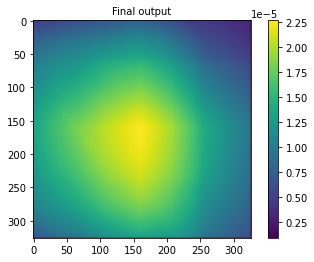

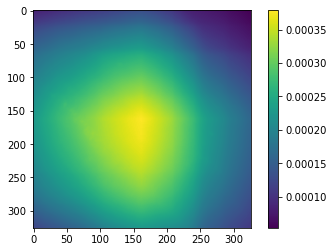

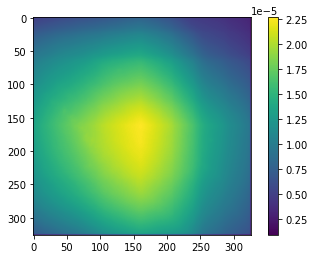

In [28]:
img = final_output.squeeze()
plt.imshow(img); plt.title("Final output",fontsize = 10)
plt.colorbar()
plt.show()

out = np.array(output_1.detach())
plt.imshow(out.squeeze())
plt.colorbar()
plt.show()

out2 = np.array(output_2.detach())
plt.imshow(out2.squeeze())
plt.colorbar()
plt.show()

# Other PSF functions

In [29]:
cd '/n/holylfs/LABS/wadduwage_lab/Lab/navodini/FwdModel_matlab/_PSFs'

/n/holylfs/LABS/wadduwage_lab/Lab/navodini/FwdModel_matlab/_PSFs


In [17]:
ls '/n/holylfs/LABS/wadduwage_lab/Lab/navodini/FwdModel_matlab/_PSFs'

2020-12-26_PSFs.mat           PSFs13-Jan-2021 02:32:14.mat
_PSFs/                        PSFs13-Jan-2021 03:28:29.mat
PSFs02-May-2021 09:13:47.mat  PSFs13-Jan-2021 04:31:03.mat
PSFs02-May-2021 17:22:42.mat  PSFs14-Apr-2021 02:35:57.mat
PSFs02-May-2021 22:52:41.mat  PSFs17-Apr-2021 04:31:27.mat
PSFs02-May-2021 22:56:18.mat  PSFs17-Apr-2021 16:18:25.mat
PSFs04-Jan-2021 00:40:18.mat  PSFs20-Apr-2021 05:40:28.mat
PSFs04-Jan-2021 02:13:34.mat  PSFs20-Apr-2021 15:35:29.mat
PSFs04-Jan-2021 03:52:28.mat  PSFs23-May-2021 02:57:32.mat
PSFs04-May-2021 06:30:22.mat  PSFs23-May-2021 14:46:23.mat
PSFs04-May-2021 09:52:47.mat  PSFs25-May-2021 01:34:24.mat
PSFs09-Jan-2021 00:39:56.mat  PSFs26-Apr-2021 05:15:18.mat
PSFs09-Jan-2021 01:08:48.mat  PSFs26-Dec-2020 23:10:09.mat
PSFs09-Jan-2021 01:10:22.mat  PSFs27-Dec-2020 00:15:44.mat
PSFs09-Jan-2021 01:12:39.mat  PSFs27-Dec-2020 00:55:30.mat
PSFs09-Jan-2021 01:31:23.mat  PSFs27-Dec-2020 02:21:44.mat
PSFs09-Jan-2021 05:07:49.mat  PSFs27-Dec-2020 03:21:32.m

In [69]:
PSFs_content = sio.loadmat('PSFs04-Jan-2021 02:13:34.mat') #'PSFs04-Jan-2021 03:52:28.mat' 

In [70]:
for fn in PSFs_content.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(PSFs_content[fn])))

# print(PSFs_content)

User uploaded file "__header__" with length 76 bytes
User uploaded file "__version__" with length 3 bytes
User uploaded file "__globals__" with length 0 bytes
User uploaded file "PSFs" with length 1 bytes


In [71]:
PSF_all = {}
keys = [('exPSF', 'O'), ('emPSF', 'O'), ('sPSF', 'O'), ('emConvSPSF', 'O'), ('pram', 'O')] #
for i in range(len(keys)):
    # print(keys[i][0])
    PSF_all[keys[i][0]] = (PSFs_content['PSFs'][0][0][i])

In [72]:
PSF_prams = {}
keys_2 = [('Nphotons', 'O'), ('NtimePts', 'O'), ('Nsims', 'O'), ('Nx', 'O'), ('dx', 'O'), ('useGpu', 'O'), ('lambda_ex', 'O'), ('lambda_em', 'O'), ('NA', 'O'), ('mus', 'O'), ('g', 'O'), ('nt', 'O'), ('nm', 'O'), ('sl', 'O'), ('z0_um', 'O'), ('savepath', 'O'), ('fNameStem', 'O'), ('fs', 'O'), ('datapath', 'O')]
for i in range(len(keys_2)):
    # print(PSF_all['pram'][0][0][i])
    # print(PSF_all['pram'][keys_2[i][0]][0][0])
    PSF_prams[keys_2[i][0]] = (PSF_all['pram'][0][0][i])
    
PSF_all['pram'] = PSF_prams

In [73]:
PSF_all.keys()

dict_keys(['exPSF', 'emPSF', 'sPSF', 'emConvSPSF', 'pram'])

In [74]:
PSF_prams

{'Nphotons': array([[1000000]], dtype=int32),
 'NtimePts': array([[1000]], dtype=uint16),
 'Nsims': array([[32]], dtype=uint8),
 'Nx': array([[1027]], dtype=uint16),
 'dx': array([[0.165]]),
 'useGpu': array([[1]], dtype=uint8),
 'lambda_ex': array([[0.8]]),
 'lambda_em': array([[0.59]]),
 'NA': array([[1]], dtype=uint8),
 'mus': array([[200]], dtype=uint8),
 'g': array([[0.9]]),
 'nt': array([[1.33]]),
 'nm': array([[1.33]]),
 'sl': array([[50]], dtype=uint8),
 'z0_um': array([[-350]], dtype=int16),
 'savepath': array(['/home/harvard/Dropbox (Harvard University)/Codes_v2/DEEP-TFM_with_cGAN/FwdModel_matlab/_PSFs/'],
       dtype='<U93'),
 'fNameStem': array(['MC'], dtype='<U2'),
 'fs': array([[24]], dtype=uint8),
 'datapath': array(['./_datasets/mnist/'], dtype='<U18')}

In [75]:
print(PSF_all['exPSF'].shape)
print(PSF_all['emPSF'].shape)
print(PSF_all['sPSF'].shape)

(1025, 1025)
(1025, 1025)
(1025, 1025)


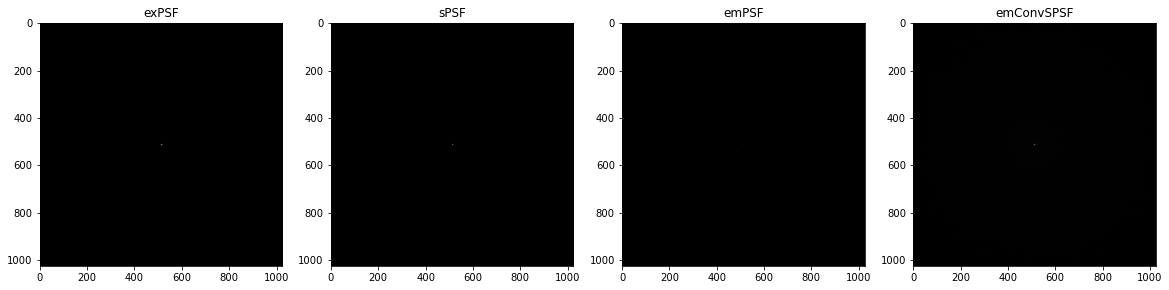

In [76]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
ax[0].imshow(PSF_all['exPSF'],cmap = 'gray'), ax[0].set_title('exPSF')
ax[1].imshow(PSF_all['emPSF'], cmap = 'gray'), ax[1].set_title('sPSF')
ax[2].imshow(PSF_all['sPSF'], cmap = 'gray'), ax[2].set_title('emPSF')
ax[3].imshow(PSF_all['emConvSPSF'], cmap = 'gray'), ax[3].set_title('emConvSPSF')
plt.show()


# Extract excitation patterns from actual data

In [35]:
cd '/n/holylfs/LABS/wadduwage_lab/Lab/navodini/FwdModel_matlab/_extPatternsets'

/n/holylfs/LABS/wadduwage_lab/Lab/navodini/FwdModel_matlab/_extPatternsets


In [36]:
!ls '/n/holylfs/LABS/wadduwage_lab/Lab/navodini/FwdModel_matlab/_extPatternsets/'

dmd_exp_tfm_beads_20200925.mat	     dmd_exp_tfm_mouse_20201224.mat
dmd_exp_tfm_beads_7sls_20201219.mat


In [37]:
mat_fname = 'dmd_exp_tfm_mouse_20201224.mat'
mat_contents = sio.loadmat(mat_fname)

In [38]:
for fn in mat_contents.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(mat_contents[fn])))

User uploaded file "__header__" with length 75 bytes
User uploaded file "__version__" with length 3 bytes
User uploaded file "__globals__" with length 0 bytes
User uploaded file "Data" with length 1 bytes


In [39]:
def pram_init():
    pram = {}
    pram['sim2dOr3d'] = '3D'               #  {'2D','3D'}
    pram['mic_typ'] = 'DMD';               # {'DMD','WGD'}
    pram['pattern_typ']  = 'dmd_exp_tfm_mouse_20201224_400um'   # {'dmd_sim_rnd','dmd_exp_tfm_beads_7sls_20201219', 'dmd_exp_tfm_mouse_20201224_sf'
    # 'dmd_exp_tfm_mouse_20201224_100um', 'dmd_exp_tfm_mouse_20201224_200um','dmd_exp_tfm_mouse_20201224_300um','dmd_exp_tfm_mouse_20201224_350um',
    # 'dmd_exp_tfm_mouse_20201224_400um','dmd_exp_tfm_mouse_20201224_all'}
    
    pram['dataset'] = 'mouse_400um';   # {'minist','andrewCells_fociW3_63x_maxProj','andrewCells_dapi_20x_maxProj','beads','mouse_sf',
    # 'mouse_100um','mouse_200um','mouse_300um','mouse_350um','mouse_400um'}
    pram['psf_typ'] = 'MC';    # {'MC','gaussian',...}
    
    ##  optical properties of the tissue
    pram['mus']        = 200;                                  # [cm^-1]   scattering coefficient of tissue
    pram['g']          = 0.90;                                 # [AU]      anisotropy of scattering of tissue
    pram['nt']         = 1.33;                                 # [AU]      refractive index of tissue  
    pram['nm']         = 1.33;                                 # [AU]      refractive index of the medium (ex:water,air)  
    pram['sl']         = (1/pram['mus'])*10*1e3;               # [um]      sacttering length 
    
    
    ## data size parameters
    pram['Nx']      = 100;
    pram['Ny']      = 100;
    pram['Nz']      = 64;
    pram['Nc']      = 1;
    pram['Nt']      = 8;
    pram['Nb']      = 1e4;                                     # number of batches (instances)
    pram['dx']      = 0.33;
    pram['dz']      = 1;
    
    
    ## MIC and imaging parameters
    pram['lambda_ex']  = 0.800;                                # [um]      excitation wavelength
    pram['lambda_em']  = 0.590;                                # [um]      emission wavelength {0.606 }
    pram['NA']         = 1;                                    # [AU]      numerical aperture of the objective
    pram['z0_um']      = -7*pram['sl'];                        # [um]      depth (z=0 is the surface and -ve is below)
    
    ## camera parameters <THIS IS OLD NEED UPDATING WITH THE NEW CAM MODEL>
    pram['binR']             = 1;
    pram['cam_emhist_Nreps'] = 10000;

    ##    run environment parameters  
    # pram['useGPU']   = gpuDeviceCount>0 ;
    return pram



In [40]:
pram = pram_init()
pram["Nt"] = 32

In [41]:
Data_all = mat_contents['Data']

In [42]:
Data = {}
keys = [('pram', 'O'), ('Ex', 'O'), ('anml1_r1_sf', 'O'), ('anml1_r1_100um', 'O'), ('anml1_r1_200um', 'O'), ('anml1_r1_300um', 'O'), ('anml1_r1_350um', 'O'), ('anml1_r1_sf_wf0', 'O'), ('anml1_r1_100um_wf0', 'O'), ('anml1_r1_200um_wf0', 'O'), ('anml1_r1_300um_wf0', 'O'), ('anml1_r1_350um_wf0', 'O'), ('anml1_r2_sf', 'O'), ('anml1_r2_100um', 'O'), ('anml1_r2_200um', 'O'), ('anml1_r2_300um', 'O'), ('anml1_r2_350um', 'O'), ('anml1_r2_sf_wf0', 'O'), ('anml1_r2_100um_wf0', 'O'), ('anml1_r2_200um_wf0', 'O'), ('anml1_r2_300um_wf0', 'O'), ('anml1_r2_350um_wf0', 'O'), ('anml2_r1_100um', 'O'), ('anml2_r1_200um', 'O'), ('anml2_r1_300um', 'O'), ('anml2_r1_350um', 'O'), ('anml2_r1_100um_wf0', 'O'), ('anml2_r1_200um_wf0', 'O'), ('anml2_r1_300um_wf0', 'O'), ('anml2_r1_350um_wf0', 'O'), ('anml2_r2_300um', 'O'), ('anml2_r2_350um', 'O'), ('anml2_r2_400um', 'O'), ('anml2_r2_300um_wf0', 'O'), ('anml2_r2_350um_wf0', 'O'), ('anml2_r2_400um_wf0', 'O'), ('dims', 'O')]
for i in range(len(keys)):
    # print(keys[i][0])
    Data[keys[i][0]] = Data_all[0][0][i]
# print(Data)
print(len(Data_all[0][0]),len(keys),len(Data))


37 37 37


In [43]:
Data['prams'] = {}
keys = ('dx0', 'O'), ('bias', 'O'), ('ADCfactor', 'O'), ('t_exp', 'O'), ('EMgain_lt300um', 'O'), ('EMgain_gt300um', 'O')
for i in range(len(keys)):
    # print(keys[i][0])
    Data['prams'][keys[i][0]] = (Data['pram'][0][0][i])
Data['prams']

{'dx0': array([[0.33]]),
 'bias': array([[300]], dtype=uint16),
 'ADCfactor': array([[0.06017571]]),
 't_exp': array([[100]], dtype=uint8),
 'EMgain_lt300um': array([[500]], dtype=uint16),
 'EMgain_gt300um': array([[1000]], dtype=uint16)}

(326, 326, 255)


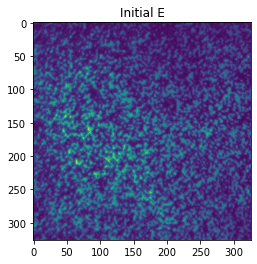

(326, 326, 255) (326, 326, 255) (326, 326, 255)


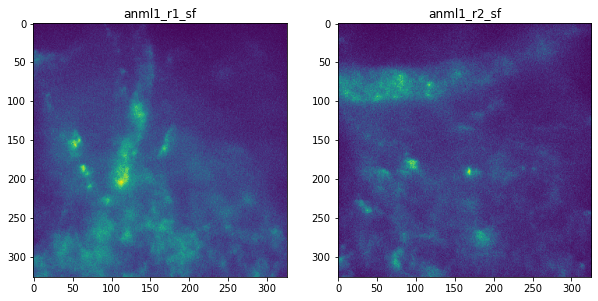

(326, 326) (326, 326)


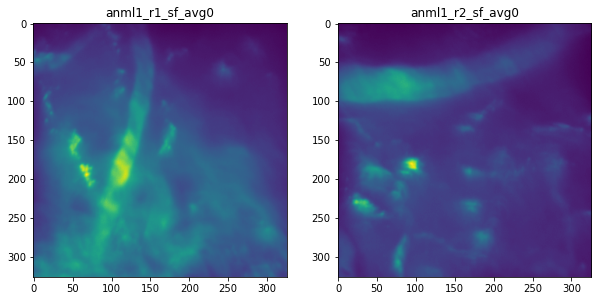

(326, 326) (326, 326)


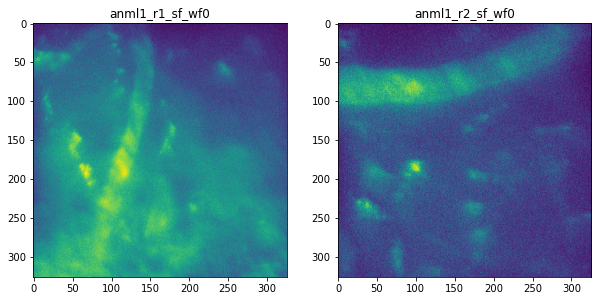

(326, 326, 32)


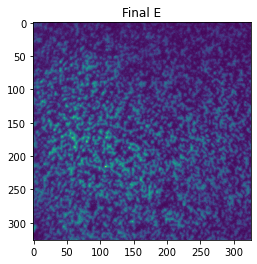

In [78]:
pram["z0_um"] = -1                                                         # [um] surface is 0 um -ve is below the surface
pram["Nx"] = min(Data['Ex'].shape[0],Data['Ex'].shape[1]);                 # make square image
pram["Ny"] = pram["Nx"]
x_inds = np.arange(start=0, stop=pram["Nx"], step=1)                       
y_inds = np.arange(start=0, stop=pram["Ny"], step=1) 
t_inds = 20 + np.arange(start=0, stop=pram["Nt"], step=1) 
print(Data['Ex'][y_inds,:,:].shape)
Y_exp = {}
X_refs = {}
k = 30
E = Data['Ex'][y_inds,:,:].astype(np.float32)
plt.imshow(E[:,:,k])
plt.title('Initial E')
plt.show()

################################
Y_exp['anml1_r1_sf'] = Data['anml1_r1_sf'][y_inds,:,:].astype(np.float32)
Y_exp['anml1_r2_sf'] = Data['anml1_r2_sf'][y_inds,:,:].astype(np.float32)
print(E.shape,Y_exp['anml1_r1_sf'].shape, Y_exp['anml1_r2_sf'].shape)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(Y_exp['anml1_r1_sf'][:,:,k]), ax[0].set_title('anml1_r1_sf')
ax[1].imshow(Y_exp['anml1_r2_sf'][:,:,k]), ax[1].set_title('anml1_r2_sf')
plt.show()

################################
X_refs['anml1_r1_sf_avg0'] = np.mean(Y_exp['anml1_r1_sf'],2)
X_refs['anml1_r2_sf_avg0'] = np.mean(Y_exp['anml1_r2_sf'],2)
print(X_refs['anml1_r1_sf_avg0'].shape, X_refs['anml1_r2_sf_avg0'].shape)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(X_refs['anml1_r1_sf_avg0']), ax[0].set_title('anml1_r1_sf_avg0')
ax[1].imshow(X_refs['anml1_r2_sf_avg0']), ax[1].set_title('anml1_r2_sf_avg0')
plt.show()

#################################
X_refs['anml1_r1_sf_wf0'] = Data['anml1_r1_sf_wf0'][y_inds,:].astype(np.float32)
X_refs['anml1_r2_sf_wf0'] = Data['anml1_r2_sf_wf0'][y_inds,:].astype(np.float32)
print(X_refs['anml1_r1_sf_avg0'].shape, X_refs['anml1_r2_sf_avg0'].shape)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(X_refs['anml1_r1_sf_wf0']), ax[0].set_title('anml1_r1_sf_wf0')
ax[1].imshow(X_refs['anml1_r2_sf_wf0']), ax[1].set_title('anml1_r2_sf_wf0')
plt.show()

########################################
E = E[:,:,t_inds]
Y_exp['anml1_r1_sf'] = Y_exp['anml1_r1_sf'][:,:,t_inds]
Y_exp['anml1_r2_sf'] = Y_exp['anml1_r2_sf'][:,:,t_inds]

#############################################
X_refs['anml1_r1_sf_avg'] = np.mean(Y_exp['anml1_r1_sf'],2)
X_refs['anml1_r2_sf_avg'] = np.mean(Y_exp['anml1_r2_sf'],2)

E = E - np.min(E[:]);
E = E/np.max(E[:]);
print(E.shape)
plt.imshow(E[:,:,k])
plt.title('Final E')
plt.show()
# print(E)

pram['maxcount'] = np.max(np.concatenate((X_refs['anml1_r1_sf_avg0'][:],X_refs['anml1_r2_sf_avg0'][:]),axis=1)) 
pram['dx'] = Data['prams']['dx0']
pram['cam_bias'] = Data['prams']['bias'];
pram['cam_ADCfactor'] = Data['prams']['ADCfactor'];
pram['cam_EMgain'] = Data['prams']['EMgain_lt300um'];
pram['cam_t_exp'] = Data['prams']['t_exp']/ 1e3;
pram['cam_ADCfactor'] = Data['prams']['ADCfactor'];
pram['cam_ADCfactor'] = Data['prams']['ADCfactor'];   # [s]  
pram['cam_sigma_rd']= 3;                              # [e-] Read noise      
pram['cam_dXdt_dark']= 0.005;                         # [e-/px/s] Dark current
pram['cam_Brnuli_alpha']= 0.01;                       #  Probability of a multiplication event in an Em gain stage (=1-2% in Ref2)
pram['cam_N_gainStages']= np.round(np.log(pram['cam_EMgain'])/np.log(1+pram['cam_Brnuli_alpha'])); #  Number of Em-gain stages
                                                           



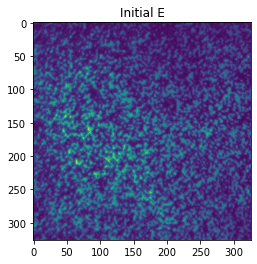

(326, 326, 255) (326, 326, 255) (326, 326, 255)


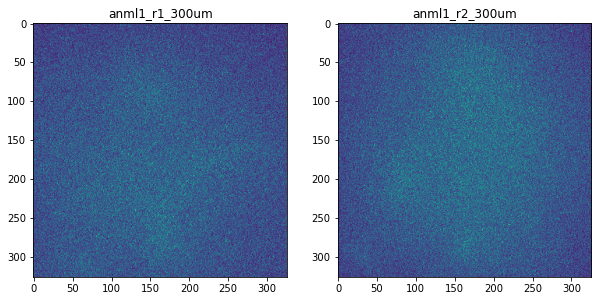

(326, 326) (326, 326)


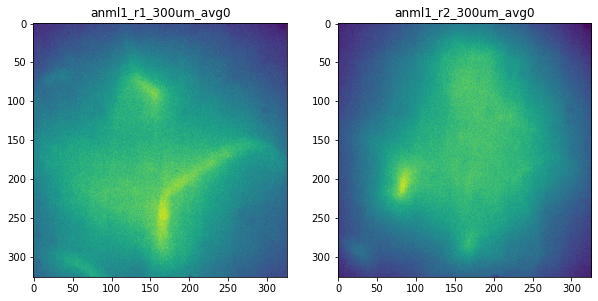

(326, 326) (326, 326)


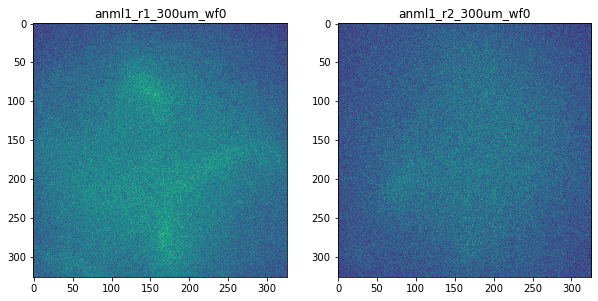

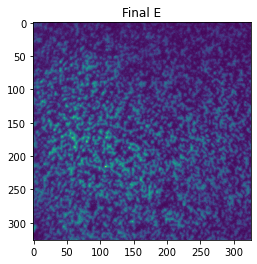

[[[0.08745248 0.13406108 0.02992764 ... 0.04256102 0.30614498 0.04525942]
  [0.11198332 0.13958053 0.02367227 ... 0.05580768 0.19587883 0.03409788]
  [0.07960261 0.1897461  0.05188275 ... 0.03054091 0.21403168 0.04844842]
  ...
  [0.12228628 0.07972526 0.03005029 ... 0.02661597 0.03225807 0.02722924]
  [0.10033117 0.05470379 0.03287134 ... 0.04059856 0.03520177 0.03507911]
  [0.03655097 0.07261132 0.05801546 ... 0.03213541 0.05519442 0.01496382]]

 [[0.06807311 0.0637802  0.04194775 ... 0.08794309 0.21366367 0.07040354]
  [0.09211334 0.12081443 0.02281369 ... 0.07886668 0.20826691 0.03765485]
  [0.1433828  0.16619651 0.05838342 ... 0.04489145 0.25683796 0.04391022]
  ...
  [0.07138477 0.10548265 0.0766589  ... 0.0244082  0.0187661  0.01999264]
  [0.03066356 0.08512204 0.05752484 ... 0.02759721 0.04072121 0.02538943]
  [0.05678892 0.02109653 0.02919171 ... 0.06672391 0.03765485 0.05102417]]

 [[0.09419846 0.04550472 0.07947995 ... 0.11652153 0.15859194 0.04575003]
  [0.14436404 0.129768

In [26]:
pram["z0_um"] = -300                                                       # [um] surface is 0 um -ve is below the surface
pram["Nx"] = min(Data['Ex'].shape[0],Data['Ex'].shape[1]);                 # make square image
pram["Ny"] = pram["Nx"]
x_inds = np.arange(start=0, stop=pram["Nx"], step=1)                       
y_inds = np.arange(start=0, stop=pram["Ny"], step=1) 
t_inds = 20 + np.arange(start=0, stop=pram["Nt"], step=1) 

Y_exp = {}
X_refs = {}
k = 30
E = Data['Ex'][y_inds,:,:].astype(np.float32)
plt.imshow(E[:,:,k])
plt.title('Initial E')
plt.show()

################################
Y_exp['anml1_r1_300um'] = Data['anml1_r1_300um'][y_inds,:,:].astype(np.float32)
Y_exp['anml1_r2_300um'] = Data['anml1_r2_300um'][y_inds,:,:].astype(np.float32)
print(E.shape,Y_exp['anml1_r1_300um'].shape, Y_exp['anml1_r2_300um'].shape)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(Y_exp['anml1_r1_300um'][:,:,k]), ax[0].set_title('anml1_r1_300um')
ax[1].imshow(Y_exp['anml1_r2_300um'][:,:,k]), ax[1].set_title('anml1_r2_300um')
plt.show()

################################
X_refs['anml1_r1_300um_avg0'] = np.mean(Y_exp['anml1_r1_300um'],2)
X_refs['anml1_r2_300um_avg0'] = np.mean(Y_exp['anml1_r2_300um'],2)
print(X_refs['anml1_r1_300um_avg0'].shape, X_refs['anml1_r2_300um_avg0'].shape)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(X_refs['anml1_r1_300um_avg0']), ax[0].set_title('anml1_r1_300um_avg0')
ax[1].imshow(X_refs['anml1_r2_300um_avg0']), ax[1].set_title('anml1_r2_300um_avg0')
plt.show()

#################################
X_refs['anml1_r1_300um_wf0'] = Data['anml1_r1_300um_wf0'][y_inds,:].astype(np.float32)
X_refs['anml1_r2_300um_wf0'] = Data['anml1_r2_300um_wf0'][y_inds,:].astype(np.float32)
print(X_refs['anml1_r1_300um_avg0'].shape, X_refs['anml1_r2_300um_avg0'].shape)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(X_refs['anml1_r1_300um_wf0']), ax[0].set_title('anml1_r1_300um_wf0')
ax[1].imshow(X_refs['anml1_r2_300um_wf0']), ax[1].set_title('anml1_r2_300um_wf0')
plt.show()

########################################
E = E[:,:,t_inds]
Y_exp['anml1_r1_300um'] = Y_exp['anml1_r1_300um'][:,:,t_inds]
Y_exp['anml1_r2_300um'] = Y_exp['anml1_r2_300um'][:,:,t_inds]

#############################################
X_refs['anml1_r1_300um_avg'] = np.mean(Y_exp['anml1_r1_300um'],2)
X_refs['anml1_r2_300um_avg'] = np.mean(Y_exp['anml1_r2_300um'],2)

E = E - np.min(E[:]);
E = E/np.max(E[:]);
plt.imshow(E[:,:,k])
plt.title('Final E')
plt.show()
print(E)

pram['maxcount'] = np.max(np.concatenate((X_refs['anml1_r1_300um_avg0'][:],X_refs['anml1_r2_300um_avg0'][:]),axis=1)) #??????????????????
pram['dx'] = Data['prams']['dx0']
pram['cam_bias'] = Data['prams']['bias'];
pram['cam_ADCfactor'] = Data['prams']['ADCfactor'];
pram['cam_EMgain'] = Data['prams']['EMgain_lt300um'];
pram['cam_t_exp'] = Data['prams']['t_exp']/ 1e3;
pram['cam_ADCfactor'] = Data['prams']['ADCfactor'];
pram['cam_ADCfactor'] = Data['prams']['ADCfactor'];   # [s]  
pram['cam_sigma_rd']= 3;                              # [e-] Read noise      
pram['cam_dXdt_dark']= 0.005;                         # [e-/px/s] Dark current
pram['cam_Brnuli_alpha']= 0.01;                       #  Probability of a multiplication event in an Em gain stage (=1-2% in Ref2)
pram['cam_N_gainStages']= np.round(np.log(pram['cam_EMgain'])/np.log(1+pram['cam_Brnuli_alpha'])); #  Number of Em-gain stages
                                                           


In [ ]:
X_refs['anml1_r1_300um_avg0']

array([[ 7.6052446,  7.5540214,  7.8862505, ...,  6.8888445,  6.636058 ,
         6.749054 ],
       [ 7.6310515,  6.998784 ,  7.735452 , ...,  6.806996 ,  6.9250135,
         6.5187545],
       [ 7.604137 ,  7.179042 ,  7.605569 , ...,  6.652742 ,  6.6131196,
         6.842771 ],
       ...,
       [ 9.760955 ,  9.706081 ,  9.78135  , ...,  9.214    ,  8.4909525,
         8.7456255],
       [ 9.288937 ,  9.975492 , 10.09338  , ...,  8.31226  ,  8.759247 ,
         8.820899 ],
       [ 9.822998 ,  9.144266 ,  9.712929 , ...,  8.703334 ,  8.729661 ,
         8.83302  ]], dtype=float32)

In [ ]:
# pram['z0_um'] = -6 *pram['sl']  # z0_um: -294.5550 (i.e. 6-sls, for mouse_300um)
# mat_fname = './_PSFs/PSFs02-May-2021 22:52:41.mat'
# PSF = sio.loadmat(mat_fname)

# Helper codes

In [ ]:
    # y_range = np.int(np.round(fft_Ny/2 - A.shape[0]/2)) 
    # y_range_end = np.int(np.round(fft_Ny/2 + A.shape[0]/2))
    # x_range = np.int(np.round(fft_Nx/2 - A.shape[1]/2))
    # x_range_end = np.int(np.round(fft_Nx/2 + A.shape[1]/2))
    # print(y_range,x_range)
    # Out2 = Out[x_range: x_range_end,y_range:y_range_end]

In [ ]:
# nb_channels = 32
# h, w = 6,6
# x = torch.randn(1, nb_channels, h, w)
# weights = torch.tensor([[0., 0., 0.],
#                         [0., 1., 0.],
#                         [0., 0., 0.]])
# weights = weights.view(1, 1, 3, 3).repeat(1, nb_channels, 1, 1)

# output = F.conv2d(x, weights)
# print(output.shape)

In [ ]:
# ((image x Patterns) * sPSF) * emPSF)
# x = (data_test[0].sqeeze() * Ex) # --> shape 326,326,32

#   emConvSPSF  = imresize(PSFs.emConvSPSF,PSFs.pram.dx/pram.dx,'bilinear');
#   emPSF       = imresize(PSFs.emPSF,PSFs.pram.dx/pram.dx,'bilinear');


In [ ]:
# No_of_patterns = Ex.shape[-1]

# pattern = torch.tensor(patterned.reshape(1,No_of_patterns,326,326),requires_grad=False)
# weights_sPSF = torch.tensor(sPSF_2d_scaled,requires_grad=False).float()
# weights_emPSF = torch.tensor(emPSF_2d_scaled,requires_grad=False).float()

# x_dim,y_dim = sPSF_2d_scaled.shape[0], sPSF_2d_scaled.shape[1]
# weights_sPSF = weights_sPSF.view(1, 1,x_dim , y_dim).repeat(1, No_of_patterns, 1, 1)
# print(weights_sPSF.shape)
# weights_emPSF = weights_emPSF.view(1, 1,x_dim , y_dim)

# output_1 = F.conv2d(pattern, weights_sPSF,padding='same')
# print(output_1.shape)
# # output_2 = F.conv2d(output_1, weights_emPSF,padding='same')
# # final_output[i,:,:] = output_2.squeeze()
